In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import time
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import CplexOptimizer

path = 'results/qmcmc/'

def collect_res(path, ntrial=10):
    for itrial in range(0, 1):
        with open(path + "res_" + str(itrial) + ".json", "r") as infile: 
            res_dict_1 = json.load(infile)

    niter = len(res_dict_1['expec'])
    mat_res_expec = np.zeros((niter, ntrial))
    mat_res_fval = np.zeros((niter, ntrial))

    for itrial in range(0, ntrial):

        with open(path + "res_" + str(itrial) + ".json", "r") as infile: 
            res_dict = json.load(infile)
        
        for i in range(0, niter):
                mat_res_expec[i, itrial] = res_dict['expec'][i][0]
                mat_res_fval[i, itrial] = res_dict['expec'][i][1]
            
    return {'expec': mat_res_expec, 'fval': mat_res_fval, 
            'last_iter': mat_res_fval[-1, :]}

#### CPLEX Runs

In [2]:
problems_dir = "/Users/vaibhawkumar/vaibhaw/projects/algos/Client-Moderna-Optimization/"
#prob_size = [10, 15, 30, 35, 40, 50]
prob_size = [50]


with open(problems_dir + 'ten_seq_by_q_50b.json', 'r') as f:
    prob_dict = json.load(f)
   
for nqubit in prob_size:
    for file in prob_dict[str(nqubit)][0:5]:
        file_name = problems_dir + 'lp_G0_lp_c/' + file + '_c.lp'
    
        target_mdl = QuadraticProgram()
        target_mdl.read_from_lp_file(file_name)

        st_time = time.time()
        cplex_result = CplexOptimizer().solve(target_mdl)
        end_time = time.time()

        cplex_res = {"optval": cplex_result.fval, "xsol": str(cplex_result.x.astype(int)), "time": (end_time - st_time)}

        res_dir = file_name.split('/')[-1].split('_')[1]

        with open('results/N_' + str(nqubit) + '/' + res_dir + "/" + "cplex_res_" + ".json", "w") as outfile:
            json.dump(cplex_res, outfile)

In [4]:
problems_dir = "/Users/vaibhawkumar/vaibhaw/projects/algos/Client-Moderna-Optimization/"
prob_size = [10, 15, 30, 35, 40, 50]


with open(problems_dir + 'ten_seq_by_q_50b.json', 'r') as f:
    prob_dict = json.load(f)

prob_size_res = {}
for nqubit in prob_size:
    psucc_list = []
    res_dir_list = []
    if nqubit == 50:
        probs = prob_dict[str(nqubit)][0:5]
        ntrial = 9
    else:
        probs = prob_dict[str(nqubit)]
        ntrial = 10
    for file in probs:
        file_name = problems_dir + 'lp_G0_lp_c/' + file + '_c.lp'
            
        res_dir = file_name.split('/')[-1].split('_')[1] 
    
        path = 'results/N_' + str(nqubit) + '/' + res_dir + '/'
        res_q = collect_res(path, ntrial=ntrial)
        
        with open(path + "cplex_res_" + ".json", "r") as infile: 
            cplex_res_dict = json.load(infile)
            
        cplex_opt_val = cplex_res_dict['optval']
        
        y_fval = np.abs(res_q['last_iter']-cplex_opt_val)
        psucc = [1 if elem < 1.0e-7 else 0 for elem in y_fval]
        
        #yerr_fval = np.std((res_q['last_iter']-cplex_opt_val)/cplex_opt_val)
        
        psucc_list.append(np.sum(psucc)/ntrial)
        res_dir_list.append(res_dir)

    prob_size_res[str(nqubit)] = {key:val for (key, val) in zip(res_dir_list, psucc_list)}

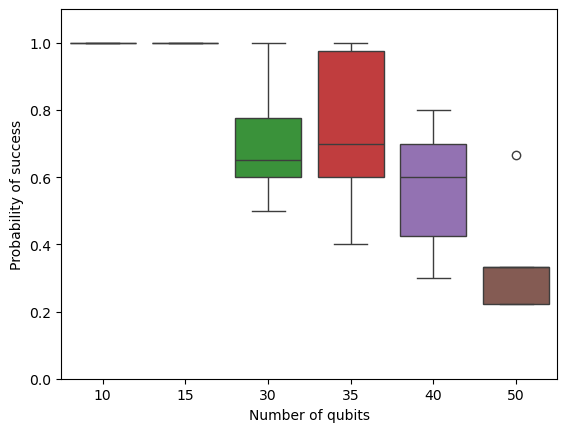

In [11]:
import seaborn as sns

sns.boxplot([list(prob_size_res[str(nqubit)].values()) for nqubit in prob_size])
plt.xticks([i for i in range(0, len(prob_size))], prob_size)
plt.xlabel("Number of qubits")
plt.ylabel("Probability of success")
plt.ylim([0.0, 1.1])
plt.savefig("mcmc_vqe.pdf", dpi=200)